<a href="https://colab.research.google.com/github/ImeldaMasika/dsc-apis-lab/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Guided Practice

1. Regression-driven EDA

    a. Checking for Linearity and Multicollinearity assumptions

2. Iterative Modeling

3. Model Evaluation

    a. Model metrics: R-squared, RMSE

    b. Assumptions: normality, homoscedasticity

    c. Coefficient analysis: unscaled vs scaled


### The Lego dataset

We are trying to predict the **list price** of a lego set via its features.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/learn-co-curriculum/dsc-scrubbing-and-cleaning-data-lab/master/Lego_data_merged.csv')
df.head()

,prod_id,ages,piece_count,set_name,prod_desc,prod_long_desc,theme_name,country,list_price,num_reviews,play_star_rating,review_difficulty,star_rating,val_star_rating
0,75823,6-12,277,Bird Island Egg Heist,Catapult into action and take back the eggs fr...,Use the staircase catapult to launch Red into ...,Angry Birds™,US,$29.99,2.0,4.0,Average,4.5,4.0
1,75822,6-12,168,Piggy Plane Attack,Launch a flying attack and rescue the eggs fro...,Pilot Pig has taken off from Bird Island with ...,Angry Birds™,US,$19.99,2.0,4.0,Easy,5.0,4.0
2,75821,6-12,74,Piggy Car Escape,Chase the piggy with lightning-fast Chuck and ...,Pitch speedy bird Chuck against the Piggy Car....,Angry Birds™,US,$12.99,11.0,4.3,Easy,4.3,4.1
3,21030,12+,1032,United States Capitol Building,Explore the architecture of the United States ...,Discover the architectural secrets of the icon...,Architecture,US,$99.99,23.0,3.6,Average,4.6,4.3
4,21035,12+,744,Solomon R. Guggenheim Museum®,Recreate the Solomon R. Guggenheim Museum® wit...,Discover the architectural secrets of Frank Ll...,Architecture,US,$79.99,14.0,3.2,Challenging,4.6,4.1


## a. Quick data cleaning

For models to fit successfully, remember all data has to be numerical (ints or floats)!

In [ ]:
# converting prices to floats
df.list_price = df.list_price.map(lambda x: float(x.replace('$', '')))

# dealing w null values
for col in df.columns:
    try:
        median = df[col].median()
        df[col] = df[col].fillna(value=median)
    except:
        continue
df.review_difficulty = df.review_difficulty.fillna('unknown')
df.isna().sum()

prod_id                0
ages                   0
piece_count            0
set_name               0
prod_desc            358
prod_long_desc         0
theme_name             0
country                0
list_price             0
num_reviews            0
play_star_rating       0
review_difficulty      0
star_rating            0
val_star_rating        0
dtype: int64

In [ ]:
# subsetting relevant columns
df = df[['ages', 'piece_count', 'theme_name', 'country', 'list_price', 'num_reviews',
         'play_star_rating', 'review_difficulty', 'star_rating', 'val_star_rating']]

# creating dummy variables and cleaning up new variable names for statsmodels
df = pd.get_dummies(df, drop_first=True)

subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

df.head()

,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating,ages_10_14,ages_10_16,ages_10_21,ages_11_16,ages_12plus,ages_12_16,ages_14plus,ages_16plus,ages_1half_3,ages_1half_5,ages_2_5,ages_4plus,ages_4_7,ages_4_99,ages_5plus,ages_5_12,ages_5_8,ages_6plus,ages_6_12,ages_6_14,ages_7plus,ages_7_12,ages_7_14,ages_8plus,ages_8_12,ages_8_14,ages_9plus,ages_9_12,ages_9_14,ages_9_16,theme_name_Architecture,theme_name_BOOST,theme_name_Blues_Helicopter_Pursuit,theme_name_BrickHeadz,...,theme_name_Marvel_Super_Heroes,theme_name_Minecraft,theme_name_Minifigures,theme_name_NEXO_KNIGHTS,theme_name_NINJAGO,theme_name_Power_Functions,theme_name_Pteranodon_Chase,theme_name_SERIOUS_PLAY,theme_name_Speed_Champions,theme_name_Star_Wars,theme_name_Stygimoloch_Breakout,theme_name_T_rex_Transport,theme_name_THE_LEGO_BATMAN_MOVIE,theme_name_THE_LEGO_NINJAGO_MOVIE,theme_name_Technic,country_AU,country_BE,country_CA,country_CH,country_CZ,country_DE,country_DN,country_ES,country_FI,country_FR,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very_Challenging,review_difficulty_Very_Easy,review_difficulty_unknown
0,277,29.99,2.0,4.0,4.5,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,168,19.99,2.0,4.0,5.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,74,12.99,11.0,4.3,4.3,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,1032,99.99,23.0,3.6,4.6,4.3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,744,79.99,14.0,3.2,4.6,4.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


## b. Regression-Driven EDA

Definitely explore parts of the dataset that intrigue you, but the most model-relevant exploration will be investigating the **linearity** and **multicollinearity** assumptions for your continuous columns.

In [ ]:
cont = ['piece_count', 'num_reviews', 'play_star_rating', 'star_rating', 'val_star_rating']

In [ ]:
df.head()

,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating,ages_10_14,ages_10_16,ages_10_21,ages_11_16,ages_12plus,ages_12_16,ages_14plus,ages_16plus,ages_1half_3,ages_1half_5,ages_2_5,ages_4plus,ages_4_7,ages_4_99,ages_5plus,ages_5_12,ages_5_8,ages_6plus,ages_6_12,ages_6_14,ages_7plus,ages_7_12,ages_7_14,ages_8plus,ages_8_12,ages_8_14,ages_9plus,ages_9_12,ages_9_14,ages_9_16,theme_name_Architecture,theme_name_BOOST,theme_name_Blues_Helicopter_Pursuit,theme_name_BrickHeadz,...,theme_name_Marvel_Super_Heroes,theme_name_Minecraft,theme_name_Minifigures,theme_name_NEXO_KNIGHTS,theme_name_NINJAGO,theme_name_Power_Functions,theme_name_Pteranodon_Chase,theme_name_SERIOUS_PLAY,theme_name_Speed_Champions,theme_name_Star_Wars,theme_name_Stygimoloch_Breakout,theme_name_T_rex_Transport,theme_name_THE_LEGO_BATMAN_MOVIE,theme_name_THE_LEGO_NINJAGO_MOVIE,theme_name_Technic,country_AU,country_BE,country_CA,country_CH,country_CZ,country_DE,country_DN,country_ES,country_FI,country_FR,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very_Challenging,review_difficulty_Very_Easy,review_difficulty_unknown
0,277,29.99,2.0,4.0,4.5,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,168,19.99,2.0,4.0,5.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,74,12.99,11.0,4.3,4.3,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,1032,99.99,23.0,3.6,4.6,4.3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,744,79.99,14.0,3.2,4.6,4.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


### Linearity Check

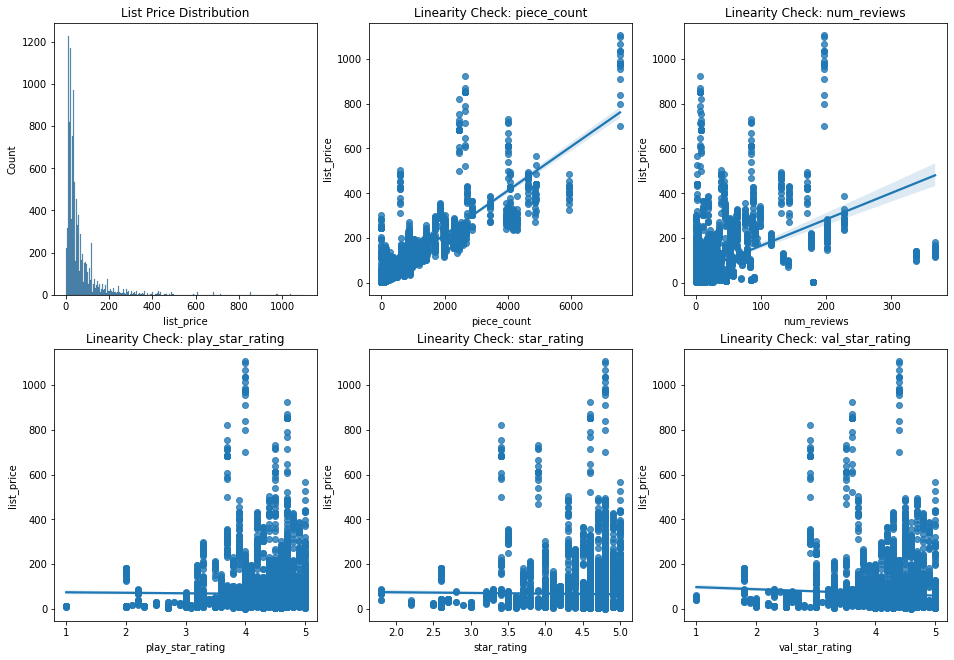

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 11))

sns.histplot(df['list_price'], ax=axes[0][0]).set_title('List Price Distribution')

# why a reg plot over a scatter plot?
for feat, ax in zip(cont, axes.flatten()[1:]):
  sns.regplot(feat,'list_price', data=df, ax=ax).set_title(f'Linearity Check: {feat}')

fig.show()

**Interpretation**

* List price has outliers on the higher end -- possibly cull in an iteration of the model
* Piece count and num_reviews has a positive correlation with the target
* The rating variables have a weak negative correlation with the target


**Notes for modeling**
* Possibly log transform the target to reduce the effect of outliers
* Culling outliers might change the correlation between rating variables and the target due to the high density of points in the 4-5-star, 0-200 price range

### Multicollinearity Check

What you might deem as "highly correlated" can be subjective and relative! Whether multicollinearity has to be dealt with can sometimes be confirmed with a baseline model.

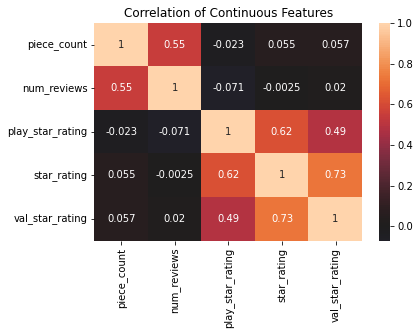

In [ ]:
corr = df[cont].corr()
sns.heatmap(corr, center=0, annot=True).set_title('Correlation of Continuous Features');

**Interpretation**

* Multicollinearity present between star_rating and val_star_rating, and between star_rating and play_star_rating


**Notes for modeling**
* Possibly drop 1 or 2 of the rating variables, depending on modeling results
* Check on num_reviews during the modeling step

## c. Iterative Modeling



In [ ]:
train, test = train_test_split(df)
train.head()

,piece_count,list_price,num_reviews,play_star_rating,star_rating,val_star_rating,ages_10_14,ages_10_16,ages_10_21,ages_11_16,ages_12plus,ages_12_16,ages_14plus,ages_16plus,ages_1half_3,ages_1half_5,ages_2_5,ages_4plus,ages_4_7,ages_4_99,ages_5plus,ages_5_12,ages_5_8,ages_6plus,ages_6_12,ages_6_14,ages_7plus,ages_7_12,ages_7_14,ages_8plus,ages_8_12,ages_8_14,ages_9plus,ages_9_12,ages_9_14,ages_9_16,theme_name_Architecture,theme_name_BOOST,theme_name_Blues_Helicopter_Pursuit,theme_name_BrickHeadz,...,theme_name_Marvel_Super_Heroes,theme_name_Minecraft,theme_name_Minifigures,theme_name_NEXO_KNIGHTS,theme_name_NINJAGO,theme_name_Power_Functions,theme_name_Pteranodon_Chase,theme_name_SERIOUS_PLAY,theme_name_Speed_Champions,theme_name_Star_Wars,theme_name_Stygimoloch_Breakout,theme_name_T_rex_Transport,theme_name_THE_LEGO_BATMAN_MOVIE,theme_name_THE_LEGO_NINJAGO_MOVIE,theme_name_Technic,country_AU,country_BE,country_CA,country_CH,country_CZ,country_DE,country_DN,country_ES,country_FI,country_FR,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US,review_difficulty_Challenging,review_difficulty_Easy,review_difficulty_Very_Challenging,review_difficulty_Very_Easy,review_difficulty_unknown
8747,1426,181.8700,5.0,2.0,2.6,1.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7604,22,36.5878,6.0,4.5,4.6,4.3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
9757,208,28.3929,16.0,4.4,4.6,4.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8718,601,454.8700,38.0,4.4,4.3,3.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2129,179,21.9478,3.0,5.0,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
target = 'list_price'
x_cols = list(df.columns)
x_cols.remove('list_price')

In [ ]:
predictors = '+'.join(x_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     558.2
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:22:05   Log-Likelihood:                -40400.
No. Observations:                8152   AIC:                         8.099e+04
Df Residuals:                    8057   BIC:                         8.166e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          189.5404     19.333      9.804      0.000     151.642     227.439
piece_count                                          0.0918      0.001     85.444      0.000       0.090       0.094
num_reviews                                          0.1696      0.019      8.961      0.000       0.133       0.207
play_star_rating                                     9.2459      1.069      8.651      0.000       7.151      11.341
star_rating                                         -2.7843      1.458     -1.910      0.056      -5.642       0.073
val_star_rating                                    -13.8934      1.014    -13.705      0.000     -15.881     -11.906
ages_10_14                                        -138.4809     11.962    -11.577      0.000    -161.930    -115.032
ages_10_16                                        -126.5510      8.436    -15.002      0.000    -143.087    -110.015
ages_10_21                                         -55.2839      5.869     -9.420      0.000     -66.788     -43.780
ages_11_16                                        -143.5253      9.411    -15.250      0.000    -161.974    -125.077
ages_12plus                                        -47.7268      7.360     -6.485      0.000     -62.154     -33.300
ages_12_16                                        -175.5993     10.240    -17.149      0.000    -195.672    -155.527
ages_14plus                                        -91.3214      8.180    -11.165      0.000    -107.355     -75.287
ages_16plus                                        -90.1354      9.471     -9.517      0.000    -108.700     -71.570
ages_1half_3                                       -40.5873      5.262     -7.714      0.000     -50.902     -30.273
ages_1half_5                                       -36.2935      5.619     -6.459      0.000     -47.309     -25.278
ages_2_5                                           -16.2872      5.000     -3.257      0.001     -26.089      -6.486
ages_4plus                                         -59.9954      9.029     -6.645      0.000     -77.694     -42.297
ages_4_7                                           -48.7790      7.221     -6.755      0.000     -62.934     -34.624
ages_4_99                                          -46.0911      7.124     -6.470      0.000     -60.056     -32.126
ages_5plus                                         -73.0071      9.951     -7.337      0.000     -92.513     -53.501
ages_5_12                                         -151.7940      7.876    -19.273      0.000    -167.233    -136.355
ages_5_8                                           -35.3465      9.091     -3.888      0.000     -53.167     -17.526
ages_6plus                               

In [ ]:
# Creating a function
# If you are transforming your target variable (likely log-transform)
# don't forget to un-transform before calculating RMSE
# Perhaps incorporate into your function!
# i.e. mean_squared_error(np.exp(y_train), np.exp(y_hat_train))

def model(train, test):

  target = 'list_price'
  x_cols = list(train.columns)
  x_cols.remove('list_price')

  predictors = '+'.join(x_cols)
  formula = target + '~' + predictors
  model = ols(formula=formula, data=train).fit()

  # RMSE
  train_err = (mean_squared_error(train['list_price'], model.predict(train)))**0.5
  test_err = (mean_squared_error(test['list_price'], model.predict(test)))**0.5

  print("Train RMSE: ", train_err)
  print("Test RMSE: ", test_err, '\n')

  return model

In [ ]:
model(train, test).summary()

Train RMSE:  34.360952281773656
Test RMSE:  36.930953060408044 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     558.2
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:26:50   Log-Likelihood:                -40400.
No. Observations:                8152   AIC:                         8.099e+04
Df Residuals:                    8057   BIC:                         8.166e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          189.5404     19.333      9.804      0.000     151.642     227.439
piece_count                                          0.0918      0.001     85.444      0.000       0.090       0.094
num_reviews                                          0.1696      0.019      8.961      0.000       0.133       0.207
play_star_rating                                     9.2459      1.069      8.651      0.000       7.151      11.341
star_rating                                         -2.7843      1.458     -1.910      0.056      -5.642       0.073
val_star_rating                                    -13.8934      1.014    -13.705      0.000     -15.881     -11.906
ages_10_14                                        -138.4809     11.962    -11.577      0.000    -161.930    -115.032
ages_10_16                                        -126.5510      8.436    -15.002      0.000    -143.087    -110.015
ages_10_21                                         -55.2839      5.869     -9.420      0.000     -66.788     -43.780
ages_11_16                                        -143.5253      9.411    -15.250      0.000    -161.974    -125.077
ages_12plus                                        -47.7268      7.360     -6.485      0.000     -62.154     -33.300
ages_12_16                                        -175.5993     10.240    -17.149      0.000    -195.672    -155.527
ages_14plus                                        -91.3214      8.180    -11.165      0.000    -107.355     -75.287
ages_16plus                                        -90.1354      9.471     -9.517      0.000    -108.700     -71.570
ages_1half_3                                       -40.5873      5.262     -7.714      0.000     -50.902     -30.273
ages_1half_5                                       -36.2935      5.619     -6.459      0.000     -47.309     -25.278
ages_2_5                                           -16.2872      5.000     -3.257      0.001     -26.089      -6.486
ages_4plus                                         -59.9954      9.029     -6.645      0.000     -77.694     -42.297
ages_4_7                                           -48.7790      7.221     -6.755      0.000     -62.934     -34.624
ages_4_99                                          -46.0911      7.124     -6.470      0.000     -60.056     -32.126
ages_5plus                                         -73.0071      9.951     -7.337      0.000     -92.513     -53.501
ages_5_12                                         -151.7940      7.876    -19.273      0.000    -167.233    -136.355
ages_5_8                                           -35.3465      9.091     -3.888      0.000     -53.167     -17.526
ages_6plus                               

### Removing Insignificant Variables

In [ ]:
# code from the Appendix lab: Modeling Your Data

model1 = model(train, test).summary()
p_table = model1.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
sig = list(p_table[p_table['P>|t|'] < 0.05].index)
sig.remove('Intercept')
print("Total # features: ", len(p_table))
print("Total significant features", len(sig))
p_table.head()

Train RMSE:  34.360952281773656
Test RMSE:  36.930953060408044 

Total # features:  99
Total significant features 58


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,189.5404,19.333,9.804,0.000,151.642,227.439
piece_count,0.0918,0.001,85.444,0.000,0.090,0.094
num_reviews,0.1696,0.019,8.961,0.000,0.133,0.207
play_star_rating,9.2459,1.069,8.651,0.000,7.151,11.341
star_rating,-2.7843,1.458,-1.910,0.056,-5.642,0.073


In [ ]:
# culling insignificant features
train2, test2 = train[sig+['list_price']], test[sig+['list_price']]

In [ ]:
train2.shape

(8152, 59)

In [ ]:
model2 = model(train2, test2)
model2.summary()

Train RMSE:  35.14637490385647
Test RMSE:  37.582823886395666 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     926.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:31:42   Log-Likelihood:                -40584.
No. Observations:                8152   AIC:                         8.128e+04
Df Residuals:                    8097   BIC:                         8.166e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          163.5963      5.521     29.634      0.000     152.775     174.418
piece_count                                          0.0928      0.001     90.088      0.000       0.091       0.095
num_reviews                                          0.1977      0.018     10.925      0.000       0.162       0.233
play_star_rating                                     8.8191      0.909      9.701      0.000       7.037      10.601
val_star_rating                                    -16.9696      0.789    -21.516      0.000     -18.516     -15.424
ages_10_14                                        -101.2423     10.497     -9.645      0.000    -121.818     -80.666
ages_10_16                                        -103.8568      5.900    -17.603      0.000    -115.422     -92.291
ages_10_21                                         -62.3380      5.535    -11.262      0.000     -73.189     -51.487
ages_11_16                                        -125.2775      7.017    -17.854      0.000    -139.032    -111.523
ages_12plus                                        -38.2858      6.236     -6.140      0.000     -50.510     -26.062
ages_12_16                                        -156.1227      8.416    -18.551      0.000    -172.620    -139.625
ages_14plus                                        -66.5949      5.966    -11.163      0.000     -78.289     -54.901
ages_16plus                                        -75.9944      7.850     -9.681      0.000     -91.383     -60.606
ages_1half_3                                       -32.8440      2.604    -12.611      0.000     -37.949     -27.739
ages_1half_5                                       -30.2517      3.280     -9.223      0.000     -36.681     -23.822
ages_2_5                                            -8.9808      2.001     -4.488      0.000     -12.903      -5.058
ages_4plus                                         -54.6522      6.593     -8.290      0.000     -67.576     -41.729
ages_4_7                                           -40.9154      3.812    -10.734      0.000     -48.388     -33.443
ages_4_99                                          -34.8782      3.744     -9.316      0.000     -42.217     -27.539
ages_5plus                                         -60.2087      3.794    -15.870      0.000     -67.646     -52.772
ages_5_12                                         -115.3746      4.833    -23.872      0.000    -124.849    -105.901
ages_5_8                                           -22.7011      6.748     -3.364      0.001     -35.929      -9.473
ages_6plus                                        -118.5276      6.846    -17.312      0.000    -131.948    -105.107
ages_6_12                                

### Post-modeling Assumption Check

Here we want to look at the **normality and homoscedasticity of residuals**.

* Residuals = Actual - Predicted
* Normality can be checked two ways: Histogram and QQ-plot ([how to interpret QQ plots](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
* Homoscedasticity can be checked via a residual plot

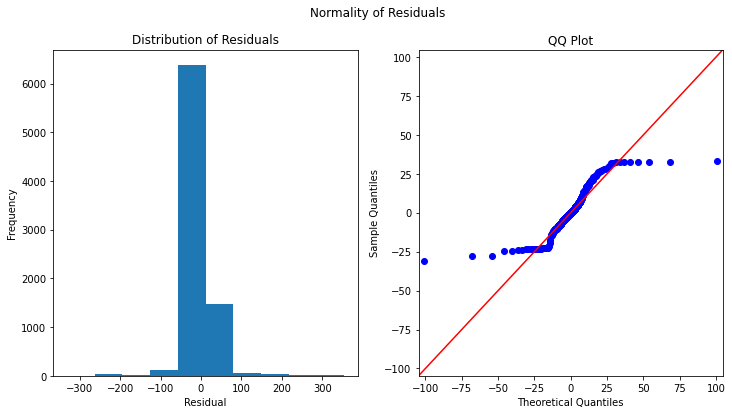

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.hist(model2.resid)
ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')

sm.qqplot(model2.resid, stats.t, fit=True, line="45", ax=ax1)
ax1.set(title='QQ Plot')

fig.suptitle('Normality of Residuals')

fig.show()

**Interpretation**: The checks for normality show that there are light tails in this model's residuals.

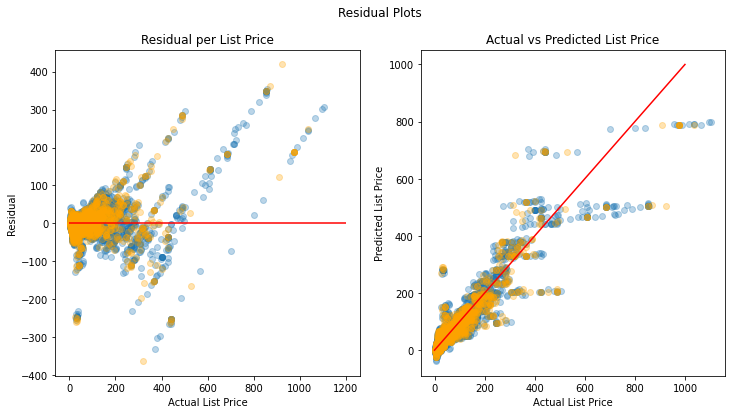

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Residual Plots')

axes[0].scatter(train2['list_price'], model2.resid, alpha=0.3)
axes[0].scatter(test2['list_price'], (test2['list_price']-model2.predict(test2)), color='orange', alpha=0.3)
axes[0].set(xlabel='Actual List Price', ylabel='Residual', title='Residual per List Price')
axes[0].hlines(0, xmin=0, xmax=1200, colors='red')

axes[1].scatter(train2['list_price'], model2.predict(train2), alpha=0.3)
axes[1].scatter(test2['list_price'], model2.predict(test2), color='orange', alpha=0.3)
axes[1].plot([0, 1000], [0, 1000], color='red', linestyle='-')
axes[1].set(xlabel='Actual List Price', ylabel='Predicted List Price', title='Actual vs Predicted List Price')
fig.show()

**Interpretation**
* Not homoscedastic, inconsistent model performace with the model mostly underpredicting above a list price of $800
* Could be due to the high skew in the target variable

## d. Coefficient Analysis

* Your final model should not have **any** variables with p-values over 0.05
* You should interpret at least 3 coefficients in your final model
* Interpretation slightly differs based on how you scaled your data

### No scaling done

* A one-unit change in {variable} leads to a {coefficient} change in `list_price`
* 1 additional piece leads to a $0.0914 increase in price

* 1 star increase in the play_star_rating leads to a $9.17 increase in price

* An age range of 10-14 leads to a $16.28 **decrease** in price


In [ ]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     926.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:50:35   Log-Likelihood:                -40584.
No. Observations:                8152   AIC:                         8.128e+04
Df Residuals:                    8097   BIC:                         8.166e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          163.5963      5.521     29.634      0.000     152.775     174.418
piece_count                                          0.0928      0.001     90.088      0.000       0.091       0.095
num_reviews                                          0.1977      0.018     10.925      0.000       0.162       0.233
play_star_rating                                     8.8191      0.909      9.701      0.000       7.037      10.601
val_star_rating                                    -16.9696      0.789    -21.516      0.000     -18.516     -15.424
ages_10_14                                        -101.2423     10.497     -9.645      0.000    -121.818     -80.666
ages_10_16                                        -103.8568      5.900    -17.603      0.000    -115.422     -92.291
ages_10_21                                         -62.3380      5.535    -11.262      0.000     -73.189     -51.487
ages_11_16                                        -125.2775      7.017    -17.854      0.000    -139.032    -111.523
ages_12plus                                        -38.2858      6.236     -6.140      0.000     -50.510     -26.062
ages_12_16                                        -156.1227      8.416    -18.551      0.000    -172.620    -139.625
ages_14plus                                        -66.5949      5.966    -11.163      0.000     -78.289     -54.901
ages_16plus                                        -75.9944      7.850     -9.681      0.000     -91.383     -60.606
ages_1half_3                                       -32.8440      2.604    -12.611      0.000     -37.949     -27.739
ages_1half_5                                       -30.2517      3.280     -9.223      0.000     -36.681     -23.822
ages_2_5                                            -8.9808      2.001     -4.488      0.000     -12.903      -5.058
ages_4plus                                         -54.6522      6.593     -8.290      0.000     -67.576     -41.729
ages_4_7                                           -40.9154      3.812    -10.734      0.000     -48.388     -33.443
ages_4_99                                          -34.8782      3.744     -9.316      0.000     -42.217     -27.539
ages_5plus                                         -60.2087      3.794    -15.870      0.000     -67.646     -52.772
ages_5_12                                         -115.3746      4.833    -23.872      0.000    -124.849    -105.901
ages_5_8                                           -22.7011      6.748     -3.364      0.001     -35.929      -9.473
ages_6plus                                        -118.5276      6.846    -17.312      0.000    -131.948    -105.107
ages_6_12                                

### Standardizing features

Looking at a model with standardized features allows us to compare the effect of variables on a level playing field.

We look at the magnitude of coefficients. i.e. most positive and most negative.

Resource for interpreting log-transformed features: https://sites.google.com/site/curtiskephart/ta/econ113/interpreting-beta

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = train2.drop('list_price', axis=1)
X_test = test2.drop('list_price', axis=1)

standardizer = StandardScaler()

train_scaled = pd.DataFrame(standardizer.fit_transform(X_train), columns=X_train.columns)
test_scaled = pd.DataFrame(standardizer.transform(X_test), columns=X_test.columns)

train_scaled['list_price'] = train2.list_price.values
test_scaled['list_price'] = test2.list_price.values

In [ ]:
train_scaled.tail()

,piece_count,num_reviews,play_star_rating,val_star_rating,ages_10_14,ages_10_16,ages_10_21,ages_11_16,ages_12plus,ages_12_16,ages_14plus,ages_16plus,ages_1half_3,ages_1half_5,ages_2_5,ages_4plus,ages_4_7,ages_4_99,ages_5plus,ages_5_12,ages_5_8,ages_6plus,ages_6_12,ages_6_14,ages_7plus,ages_7_12,ages_7_14,ages_8plus,ages_8_12,ages_8_14,ages_9_12,ages_9_14,ages_9_16,theme_name_Architecture,theme_name_BOOST,theme_name_BrickHeadz,theme_name_Carnotaurus_Gyrosphere_Escape,theme_name_Classic,theme_name_Creator_Expert,theme_name_DUPLO,theme_name_Ghostbusters,theme_name_Ideas,theme_name_Indoraptor_Rampage_at_Lockwood_Estate,theme_name_Juniors,theme_name_Minifigures,theme_name_SERIOUS_PLAY,country_BE,country_CA,country_CZ,country_DN,country_FI,country_LU,country_NO,country_PL,country_US,review_difficulty_Easy,review_difficulty_Very_Easy,review_difficulty_unknown,list_price
8147,-0.432193,-0.232946,0.043288,-0.360683,-0.041477,-0.110308,-0.134570,-0.079344,-0.170009,-0.05975,-0.135042,-0.194109,-0.145499,-0.099553,-0.276249,-0.044346,-0.240005,-0.170391,-0.067524,3.380359,-0.039966,-0.119091,-0.397021,-0.132188,-0.015665,-0.268716,-0.352943,-0.141492,-0.179696,-0.333969,-0.063754,-0.213378,-0.091715,-0.143286,-0.041477,-0.20279,-0.048334,-0.176396,-0.17191,-0.336007,-0.048334,-0.111442,-0.041477,-0.243699,-0.067524,-0.089653,-0.216812,-0.267928,-0.217432,-0.220813,-0.219281,-0.223851,-0.219281,-0.214006,-0.266611,1.350804,-0.303122,-0.439157,24.3878
8148,-0.159248,-0.289417,0.216356,0.120385,-0.041477,-0.110308,-0.134570,-0.079344,-0.170009,-0.05975,-0.135042,-0.194109,-0.145499,-0.099553,-0.276249,-0.044346,-0.240005,-0.170391,-0.067524,-0.295827,-0.039966,-0.119091,2.518758,-0.132188,-0.015665,-0.268716,-0.352943,-0.141492,-0.179696,-0.333969,-0.063754,-0.213378,-0.091715,-0.143286,-0.041477,-0.20279,-0.048334,-0.176396,-0.17191,-0.336007,-0.048334,-0.111442,-0.041477,-0.243699,-0.067524,-0.089653,-0.216812,-0.267928,-0.217432,-0.220813,-0.219281,-0.223851,-0.219281,-0.214006,-0.266611,-0.740300,-0.303122,2.277088,55.9860
8149,-0.467217,-0.289417,0.216356,0.120385,-0.041477,-0.110308,-0.134570,-0.079344,-0.170009,-0.05975,-0.135042,-0.194109,-0.145499,-0.099553,-0.276249,-0.044346,4.166577,-0.170391,-0.067524,-0.295827,-0.039966,-0.119091,-0.397021,-0.132188,-0.015665,-0.268716,-0.352943,-0.141492,-0.179696,-0.333969,-0.063754,-0.213378,-0.091715,-0.143286,-0.041477,-0.20279,-0.048334,-0.176396,-0.17191,-0.336007,-0.048334,-0.111442,-0.041477,4.103422,-0.067524,-0.089653,-0.216812,-0.267928,-0.217432,-0.220813,-0.219281,-0.223851,-0.219281,-0.214006,-0.266611,-0.740300,-0.303122,2.277088,24.3878
8150,-0.604897,-0.430597,1.081694,0.120385,-0.041477,-0.110308,7.431062,-0.079344,-0.170009,-0.05975,-0.135042,-0.194109,-0.145499,-0.099553,-0.276249,-0.044346,-0.240005,-0.170391,-0.067524,-0.295827,-0.039966,-0.119091,-0.397021,-0.132188,-0.015665,-0.268716,-0.352943,-0.141492,-0.179696,-0.333969,-0.063754,-0.213378,-0.091715,-0.143286,-0.041477,-0.20279,-0.048334,-0.176396,-0.17191,-0.336007,-0.048334,-0.111442,-0.041477,-0.243699,-0.067524,-0.089653,-0.216812,-0.267928,4.599149,-0.220813,-0.219281,-0.223851,-0.219281,-0.214006,-0.266611,1.350804,-0.303122,-0.439157,33.5520
8151,-0.368184,-0.204710,-0.822050,-0.521039,-0.041477,-0.110308,-0.134570,-0.079344,-0.170009,-0.05975,-0.135042,-0.194109,-0.145499,-0.099553,-0.276249,-0.044346,-0.240005,-0.170391,-0.067524,-0.295827,-0.039966,-0.119091,2.518758,-0.132188,-0.015665,-0.268716,-0.352943,-0.141492,-0.179696,-0.333969,-0.063754,-0.213378,-0.091715,-0.143286,-0.041477,-0.20279,-0.048334,-0.176396,-0.17191,-0.336007,-0.048334,-0.111442,-0.041477,-0.243699,-0.067524,-0.089653,-0.216812,-0.267928,-0.217432,-0.220813,-0.219281,-0.223851,-0.219281,-0.214006,-0.266611,1.350804,-0.303122,-0.439157,30.4980


* Features that most positively impact price: `piece_count`, theme being "serious play"
* Most negatively impact price: ages being younger (7-14, 6-12...)

In [ ]:
scaled_model = model(train_scaled, test_scaled)
scaled_model.summary()

Train RMSE:  35.14637490385646
Test RMSE:  37.58282388639561 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             list_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     926.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:52:56   Log-Likelihood:                -40584.
No. Observations:                8152   AIC:                         8.128e+04
Df Residuals:                    8097   BIC:                         8.166e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           67.0041      0.391    171.547      0.000      66.238      67.770
piece_count                                         76.8015      0.853     90.088      0.000      75.130      78.473
num_reviews                                          7.0015      0.641     10.925      0.000       5.745       8.258
play_star_rating                                     5.0957      0.525      9.701      0.000       4.066       6.125
val_star_rating                                    -10.5824      0.492    -21.516      0.000     -11.547      -9.618
ages_10_14                                          -4.1920      0.435     -9.645      0.000      -5.044      -3.340
ages_10_16                                         -11.3185      0.643    -17.603      0.000     -12.579     -10.058
ages_10_21                                          -8.2396      0.732    -11.262      0.000      -9.674      -6.805
ages_11_16                                          -9.8779      0.553    -17.854      0.000     -10.962      -8.793
ages_12plus                                         -6.3261      1.030     -6.140      0.000      -8.346      -4.306
ages_12_16                                          -9.2952      0.501    -18.551      0.000     -10.277      -8.313
ages_14plus                                         -8.8320      0.791    -11.163      0.000     -10.383      -7.281
ages_16plus                                        -14.2156      1.468     -9.681      0.000     -17.094     -11.337
ages_1half_3                                        -8.5020      0.485    -17.524      0.000      -9.453      -7.551
ages_1half_5                                        -5.6265      0.436    -12.904      0.000      -6.481      -4.772
ages_2_5                                            -9.1903      0.639    -14.390      0.000     -10.442      -7.938
ages_4plus                                          -3.5938      0.424     -8.479      0.000      -4.425      -2.763
ages_4_7                                           -11.9035      0.564    -21.112      0.000     -13.009     -10.798
ages_4_99                                          -10.1712      0.436    -23.306      0.000     -11.027      -9.316
ages_5plus                                          -4.0471      0.255    -15.870      0.000      -4.547      -3.547
ages_5_12                                          -31.3843      1.315    -23.872      0.000     -33.961     -28.807
ages_5_8                                            -1.3662      0.398     -3.432      0.001      -2.147      -0.586
ages_6plus                                         -13.9182      0.804    -17.312      0.000     -15.494     -12.342
ages_6_12                                